## Parcial Parte B

Consultas con SQL desde Athena

##### Abrimos una sesión de AWS y creamos la base de datos en Athena, con un chequeo por si ya existe

In [2]:
# Import required libraries
import boto3
import awswrangler as wr


# Create AWS session - this needs to be available for all chunks
session = boto3.Session(profile_name='arquitectura',
                        region_name='us-east-1')

In [3]:
# Crear la base de datos en Glue/Athena sólo si no existe
#Check if the database exists
client = session.client('glue')
athena_client = session.client("athena")
try:
    response = client.get_database(Name='profeco')
    print("La base de datos ya existe.")
except client.exceptions.EntityNotFoundException:
    print("La base de datos no existe. Creando la base de datos...")
    wr.catalog.create_database(
    name="profeco",
    description="Base de datos para análisis de datos de Profeco",
    boto3_session=session
    )


La base de datos ya existe.


##### Creamos la tabla

In [4]:
# Ruta del bucket donde están los datos particionados
#Como todas las preguntas son referentes a la categoría básicos, sólo bajamos esa partición.

s3_path = "s3://itam-analytics-marta/profeco/parquet/catalogo=basicos"

# Crear la tabla particionada
#columnas que no son particiones
columns_types = {
    "producto": "string",
    "marca": "string",
    "tipo": "string",
    "precio": "float" ,
    "fecha": "date",
    "estado": "string",
    "ciudad": "string"
}

wr.catalog.create_parquet_table(
    database="profeco",
    table="datos_basicos",
    path=s3_path,
    columns_types=columns_types,
    partitions_types={
        "anio": "int"
    },
    description="Datos de Profeco con particiones por catálogo y año",
    compression="snappy",
    mode="overwrite",
    catalog_versioning=True,
    boto3_session=session
)

wr.s3.store_parquet_metadata(
    path=s3_path,
    database="profeco",
    table="datos_basicos",
    dataset=True,
    mode="update",
    boto3_session=session
)

({'producto': 'string',
  'marca': 'string',
  'tipo': 'string',
  'precio': 'float',
  'fecha': 'date',
  'estado': 'string',
  'ciudad': 'string'},
 {'anio': 'string'},
 {'s3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2018/': ['2018'],
  's3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2019/': ['2019'],
  's3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2020/': ['2020'],
  's3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2021/': ['2021'],
  's3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2022/': ['2022'],
  's3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2023/': ['2023'],
  's3://itam-analytics-marta/profeco/parquet/catalogo=basicos/anio=2024/': ['2024']})

## Consultas de SQL

Como los cobros de Athena son por consulta, las consultas se hacen en un bloque distinto a la impresión de los resultados, para poder mejorar la salida, si hiciera falta, sin necesidad de volver a ejecutar la consulta. 


Todas las consultas son en relación al catálogo BASICOS. 



#### ¿De qué año a qué año tienen datos de esa categoría?

In [4]:
#Query: para BASICOS, saber de qué año hay datos:
# Definir la consulta SQL
query = """
SELECT DISTINCT anio
FROM profeco.datos_basicos
ORDER BY anio;
"""

# Ejecutar la consulta y obtener el resultado en un DataFrame
df_resultado = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)


In [6]:
# Mostrar los resultados
df_resultado

,anio
0,2018
1,2019
2,2020
3,2021
4,2022
5,2023
6,2024


#### ¿Cuántos registros de fecha hay vacíos?

In [ ]:
#Del catalogo BASICOS, contar registro de fecha vacíos
query="""
SELECT COUNT(*) AS registros_vacios
FROM profeco.datos_basicos
WHERE fecha IS NULL;
"""
# Ejecutar la consulta y obtener el resultado en un DataFrame
df_registros_vacios = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)


In [8]:
# Mostrar los resultados
if (df_registros_vacios['registros_vacios'][0] == 0):
    print("No hay registros vacíos en la columna fecha del catálogo BASICOS")
else:
    print(f"Hay {df_registros_vacios['registros_vacios'][0]} registros vacíos en la columna fecha del catálogo BASICOS")

No hay registros vacíos en la columna fecha del catálogo BASICOS


#### ¿Cuántos registros tienes por año?

In [9]:
#Nº de registros por año para el catálobo BASICOS
query = """
    SELECT anio, COUNT(*) as num_registros
    FROM profeco.datos_basicos
    GROUP BY anio
    ORDER BY anio
"""
df_registros_anio = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)

In [10]:
#Mostrar los resultados
df_registros_anio



,anio,num_registros
0,2018,8802747
1,2019,7398860
2,2020,6170515
3,2021,6919470
4,2022,7945081
5,2023,7742108
6,2024,1986577


#### ¿Cuál es el precio mínimo, máximo, promedio, desviación estándar, mediana, cuantil 25 y 75% de tu categoría por año?

In [11]:
#De la columna 'basicos': precio mínimo, máximo, promedio, desviación estándar, mediana, cuantil 25 y 75% por año
query = """
SELECT anio,    
    MIN(precio) AS min_precio,
    MAX(precio) AS max_precio,
    AVG(precio) AS avg_precio,
    STDDEV(precio) AS std_precio,
    approx_percentile(precio, 0.5) AS median_precio,
    approx_percentile(precio, 0.25) AS q25_precio,
    approx_percentile(precio, 0.75) AS q75_precio
FROM profeco.datos_basicos
GROUP BY anio
ORDER BY anio
"""
df_precios_summary = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)

In [12]:
#Mostrar resultados
df_precios_summary

,anio,min_precio,max_precio,avg_precio,std_precio,median_precio,q25_precio,q75_precio
0,2018,1.0,899.000000,46.446709,48.807092,29.934977,16.891520,54.832272
1,2019,1.0,659.900024,47.617153,50.498669,30.555307,17.009706,56.493664
2,2020,1.0,844.900024,51.223469,53.187706,32.562843,18.681688,61.521259
3,2021,1.0,798.900024,53.788601,56.237502,34.204407,20.092363,64.722641
4,2022,1.0,690.000000,59.717037,62.383893,38.420010,22.861570,71.460144
5,2023,1.2,869.000000,65.701469,68.851441,42.176987,24.727793,79.454872
6,2024,1.3,799.000000,66.911766,70.214783,41.868145,25.815166,81.014961


####  ¿Cuáles son el top 5 de marcas con mayor precio en cada estado? ¿Verifica si te dió lo mismo en Spark?

Al igual que hicimos en la Parte A, consideramos el precio promedio a lo largo de los años del par **producto-marca**.

In [5]:
#5 productos con sus respectivas marcas con mayor precio para cada estado.

query = """
WITH avg_price_table AS (
    SELECT
        producto,
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m' 
            ELSE marca 
        END AS marca_normalizada,
        estado,
        AVG(precio) AS precio_promedio
    FROM profeco.datos_basicos
    WHERE precio IS NOT NULL
    GROUP BY
        producto,
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m' 
            ELSE marca 
        END,
        estado
),
top5_table AS (
    SELECT
        producto,
        marca_normalizada,
        estado,
        precio_promedio,
        ROW_NUMBER() OVER(PARTITION BY estado ORDER BY precio_promedio DESC) AS row_num
    FROM avg_price_table
)
SELECT
    producto,
    marca_normalizada AS marca,
    estado,
    precio_promedio,
    row_num
FROM top5_table
WHERE row_num <= 5
ORDER BY estado, row_num

"""

df_top5_estados =wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)

In [ ]:
#Mostrar los resultados

for estado, grupo in sorted(df_top5_estados.groupby('estado')):
    print(f"\n======\nESTADO = {estado}\n======")
    print(grupo[['producto', 'marca', 'precio_promedio']].to_string(index=False))




ESTADO = aguascalientes
      producto                   marca  precio_promedio
copa menstrual                saba cup       573.354187
copa menstrual              diva cup 2       541.109985
copa menstrual              diva cup 1       505.576660
          nuez                     s/m       422.313232
       tequila jose cuervo tradicional       368.824097

ESTADO = baja california
      producto                   marca  precio_promedio
copa menstrual              diva cup 1       550.375000
copa menstrual                saba cup       543.076904
          nuez                     s/m       473.045044
     almendras                     s/m       351.481415
       tequila jose cuervo tradicional       325.915985

ESTADO = baja california sur
      producto                   marca  precio_promedio
copa menstrual              diva cup 2       644.066650
copa menstrual              diva cup 1       604.065552
copa menstrual                saba cup       551.508484
          nuez         

Estos resultados son consistentes con los obtenidos en la PARTE-A, lo cual es lógico ya que estamos utilizando los mismos datos. 

#### ¿Cuáles son el top 5 de marcas con menor precio en CDMX? (en aquel entonces Distrito Federal) ¿Verifica si te dió lo mismo en Spark?

In [10]:
#5 productos de menor precio con sus respectivas marcas para CDMX.
query = """
WITH precios_cdmx AS (
    SELECT
        producto,
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m'
            ELSE marca
        END AS marca_normalizada,
        AVG(precio) AS precio_promedio
    FROM profeco.datos_basicos
    WHERE estado = 'ciudad de mexico'
      AND precio IS NOT NULL
    GROUP BY 1, 2
),
top5_menor_precio AS (
    SELECT 
        *,
        ROW_NUMBER() OVER (ORDER BY precio_promedio ASC) AS row_num
    FROM precios_cdmx
)
SELECT producto, marca_normalizada AS marca, precio_promedio
FROM top5_menor_precio
WHERE row_num <= 5
ORDER BY precio_promedio ASC;
"""

df_top5_cdmx = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)




In [ ]:
df_top5_cdmx

,producto,marca,precio_promedio
0,pan blanco bolillo,s/m,1.791665
1,polvo p/preparar bebidas,frutimax,2.356472
2,polvo p/preparar bebidas,clight,3.165304
3,pasta para sopa,soriana,3.312400
4,polvo p/preparar bebidas,livean,3.331468


Al ibual quue ocurría en la PARTE-A, y considerando el precio promedio a lo largo de los años, los productos más baratos en la CDMX son el pan de bolillo, y el polvo para preparar bebidas. 

##### ¿Cuáles son el top 5 de marcas con mayores observaciones? ¿Se parecen a las de nivel por estado? ¿Verifica si te dió lo mismo en Spark?

In [12]:
# Top 5 marcas con mayores observaciones 
query = """
WITH marcas_limpias AS (
    SELECT 
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m'
            ELSE marca
        END AS marca_normalizada
    FROM profeco.datos_basicos
)
SELECT 
    marca_normalizada AS marca,
    COUNT(*) AS total_observaciones
FROM marcas_limpias
GROUP BY 1
ORDER BY total_observaciones DESC
LIMIT 5;
"""

df_top5_marcas = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)

In [13]:
df_top5_marcas

,marca,total_observaciones
0,s/m,2763012
1,la costena,1311513
2,fud,1151111
3,bimbo,819541
4,lala,750189


Las marcas con mayores observaciones, coinciden con las observadas utilizando consultas de SPARK, lo cual es lógico, ya que son los mismos datos. 

Desglosamos ahora las observaciones por estado, para comparar mejor con los resultados de la PARTE-A. 

In [25]:

query = """
WITH marcas_limpias AS (
    SELECT 
        estado,
        CASE 
            WHEN marca IN ('s/m', 'sin marca', 'cualquier marca') THEN 's/m'
            ELSE marca
        END AS marca_normalizada
    FROM profeco.datos_basicos
),
ranking AS (
    SELECT 
        estado,
        marca_normalizada AS marca,
        COUNT(*) AS total_obs,
        ROW_NUMBER() OVER (PARTITION BY estado ORDER BY COUNT(*) DESC) AS row_num
    FROM marcas_limpias
    GROUP BY estado, marca_normalizada
)
SELECT estado, marca, total_obs
FROM ranking
WHERE row_num <= 5
ORDER BY total_obs DESC;
"""
df_rank_marca_estado = wr.athena.read_sql_query(
    sql=query,
    database="profeco",
    boto3_session=session
)


In [26]:
df_rank_marca_estado.info()
for estado, grupo in sorted(df_rank_marca_estado.groupby('estado')):
    print(f"\n======\nESTADO = {estado}\n======")
    print(grupo[['marca', 'total_obs']].to_string(index=False)) 


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 160 entries, 0 to 159
Data columns (total 3 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   estado     160 non-null    string
 1   marca      160 non-null    string
 2   total_obs  160 non-null    Int64 
dtypes: Int64(1), string(2)
memory usage: 4.0 KB

ESTADO = aguascalientes
     marca  total_obs
       s/m      52322
       fud      20041
la costena      18908
     bimbo      15595
      lala      12561

ESTADO = baja california
     marca  total_obs
       s/m      47708
la costena      21335
       fud      15562
     bimbo      14915
      lala      13911

ESTADO = baja california sur
     marca  total_obs
       s/m      44265
la costena      20512
       fud      17289
     bimbo      13981
      lala      13378

ESTADO = campeche
     marca  total_obs
       s/m      43183
       fud      24039
la costena      22587
     bimbo      15845
  sabritas      15223

ESTADO = chiapas
      

Y vemos que las marcas con mayor número de observaciones, son las mismas en la mayoría de los estados. Con pequeñas diferencias. Del mismo modo, estos resultados son consistentes con los obtenidos en la PARTE-A

#### Genera un boxplot por año, para cada una de las top 5 marcas de tu categoría.

Recuperamos las 5 marcas con mayor número de observaciones y lo convertimos a lista para poder hacer el siguiente query.  


Sobre esas marcas, hacemos un query para obtener el precio por año y lo guardamos en un dataframe para realizar el gráfico. 

In [28]:
top5_marcas =df_top5_marcas["marca"].tolist()
print("Top 5 marcas:", top5_marcas)

Top 5 marcas: ['s/m', 'la costena', 'fud', 'bimbo', 'lala']


In [29]:
query_boxplot = f"""
SELECT 
    anio,
    marca,
    precio
FROM profeco.datos_basicos
WHERE marca IN ({','.join([f"'{m}'" for m in top5_marcas])})
  AND precio IS NOT NULL
  AND CAST(anio AS INTEGER) BETWEEN 2018 AND 2024
"""

df_boxplot = wr.athena.read_sql_query(
    sql=query_boxplot,
    database="profeco",
    boto3_session=session
)

Generamos un diagrama de caja por año, para cada una de las 5 marcas. 

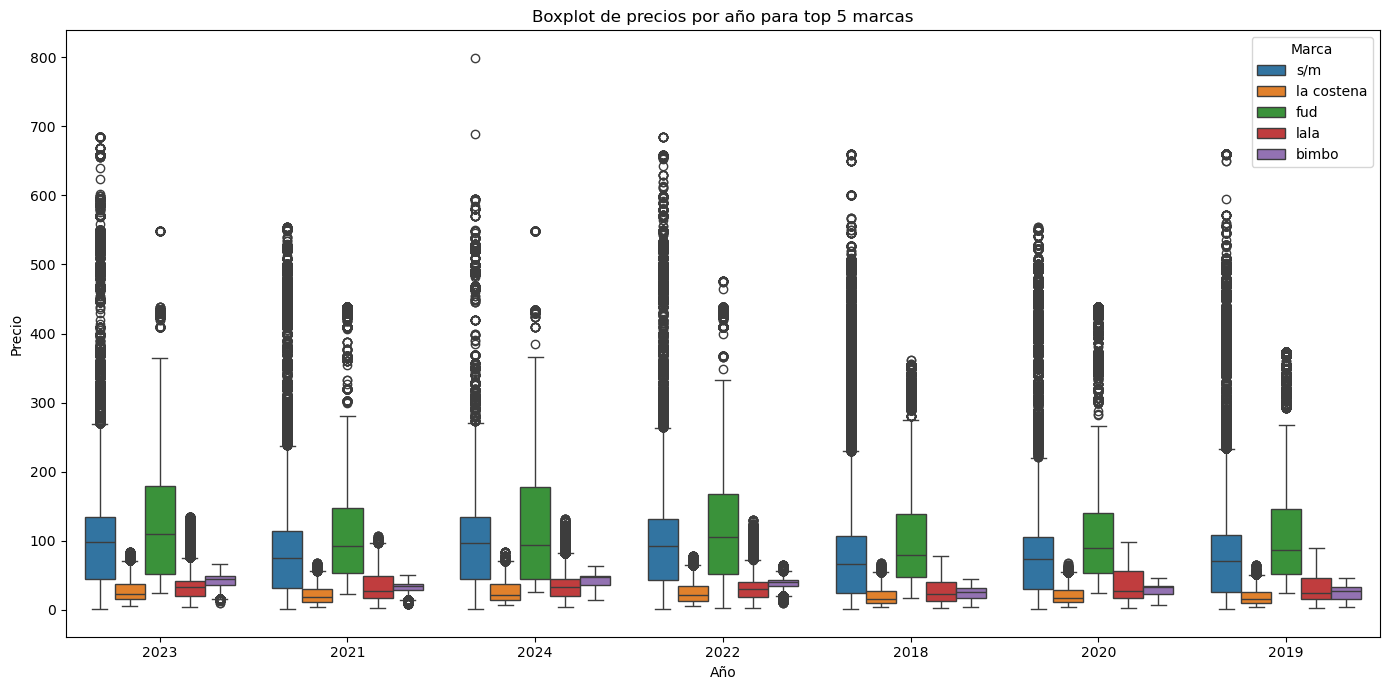

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns

plt.figure(figsize=(14, 7))
sns.boxplot(data=df_boxplot, x="anio", y="precio", hue="marca")
plt.title("Boxplot de precios por año para top 5 marcas")
plt.xlabel("Año")
plt.ylabel("Precio")
plt.legend(title="Marca")
plt.tight_layout()
plt.show()

En el gráfico se observa una gran variabilidad en el precio de las marcas, lo cual apoya nuestra decisión de utilizar en todo momento el par **producto-marca**, que es mucho más representativo, que sólo ver qué pasó con ciertas marcas. Además, la marca con más observaciones es "s/m" que es la abreviatura de "sin marca", lo cual puede abarcar una gran cantidad de productos básicos, y se corrobora con la gran variabilidad en sus precios. Bimbo, por ejemplo, que es una marca más especializada en pan, y bollería, tiene precios más estables. Lo mismo podríamos decir de "La Costeña". Mientras que "FUD" que se especializa en carnes frías, tiene más variabilidad, por las distintas calidades y presentaciones de sus productos. 